In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/fussgängerzahlen.csv")
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%dT%XZ")

df = df[["timestamp", "location_id", "weather_condition", "temperature", "adult_pedestrians_count", "child_pedestrians_count"]]
df["pedestrians_count"] = (df.adult_pedestrians_count + df.child_pedestrians_count).round(0).astype(int)
df.drop(columns=["adult_pedestrians_count","child_pedestrians_count"], inplace=True)

df = pd.get_dummies(df, columns=["weather_condition"], drop_first=True)
df.columns = df.columns.str.replace("weather_condition_", "")

df_features = df[["timestamp", "temperature", "clear-night", "cloudy", "fog", "partly-cloudy-day", "partly-cloudy-night", "rain", "snow", "wind"]]
df_features = df_features.groupby(by="timestamp").mean().reset_index()

df_wide = df.pivot(index="timestamp", columns=["location_id"], values="pedestrians_count").reset_index().rename_axis(None, axis=1)
df_wide = df_wide.rename(columns={"timestamp": "datetime", 329: "bhfs_south", 330: "bhfs_middle", 331: "bhfs_north"})

df_new = pd.merge(df_wide, df_features, left_on="datetime", right_on="timestamp", how="left")
df_new.drop(columns=["timestamp"], inplace=True)
df_new["weekday"] = df_new["datetime"].dt.weekday
df_new.replace(0, np.nan, inplace=True) # replace 0's with NaNs

Imputation of bhfs_south, bhfs_middle and temperature

In [3]:
from sklearn.impute import KNNImputer

# Assuming df_ii is your DataFrame
columns_to_impute = ["bhfs_middle", "bhfs_south", "temperature"]

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=2)

# Fit and transform the selected columns in the original DataFrame
df_new[columns_to_impute] = imputer.fit_transform(df_new[columns_to_impute])

Imputation of bhfs_norths with 3 different methods

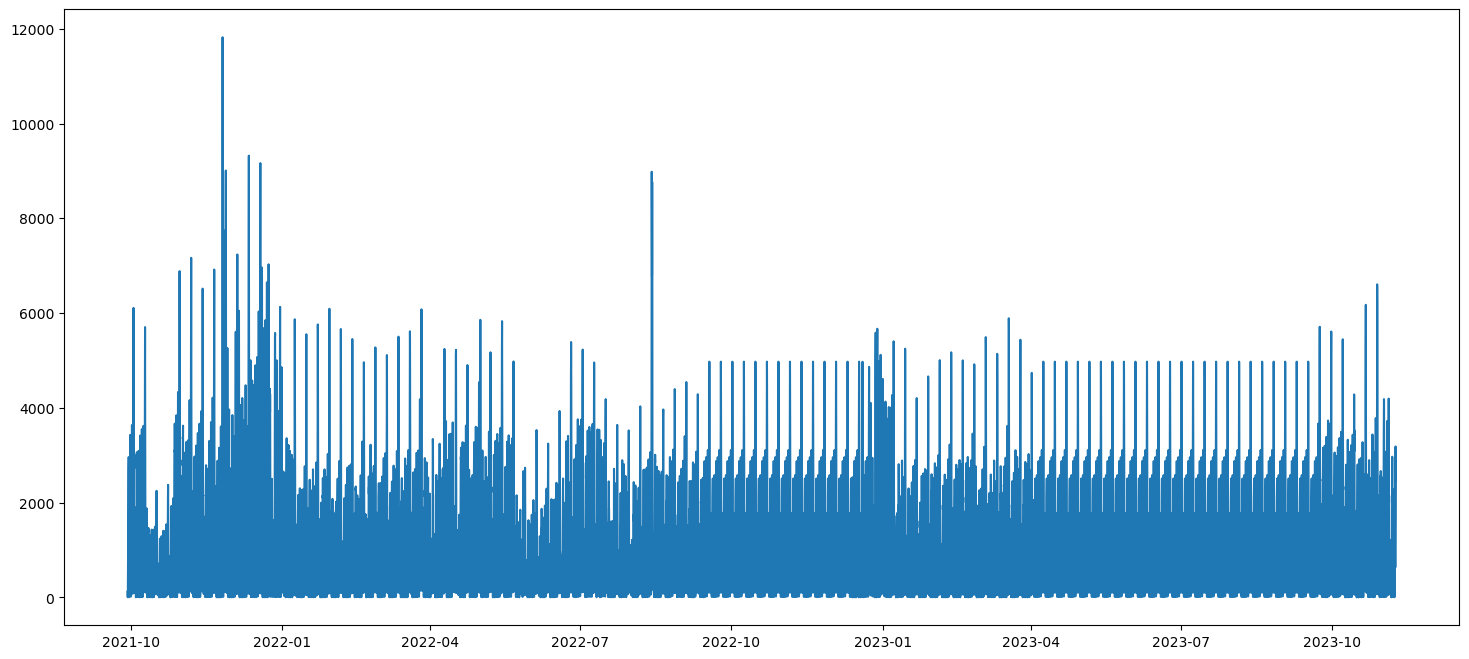

In [4]:
# Mean imputation

import math

df_mean = df_new[["datetime", "bhfs_south", "bhfs_middle", "bhfs_north"]].copy()

# Step 1: Calculate mean values for non-NaN entries
non_zero_means = df_mean[df_mean['bhfs_north'].notna()].groupby([
    df_mean['datetime'].dt.weekday, 
    df_mean['datetime'].dt.time
])['bhfs_north'].mean()

# Step 2: Replace NaN values with the calculated means
df_mean['bhfs_north'] = df_mean.apply(lambda row: non_zero_means.get(
    (row['datetime'].weekday(), row['datetime'].time()), row['bhfs_north']
) if math.isnan(row['bhfs_north']) else row['bhfs_north'], axis=1)

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_mean.datetime, df_mean.bhfs_north);

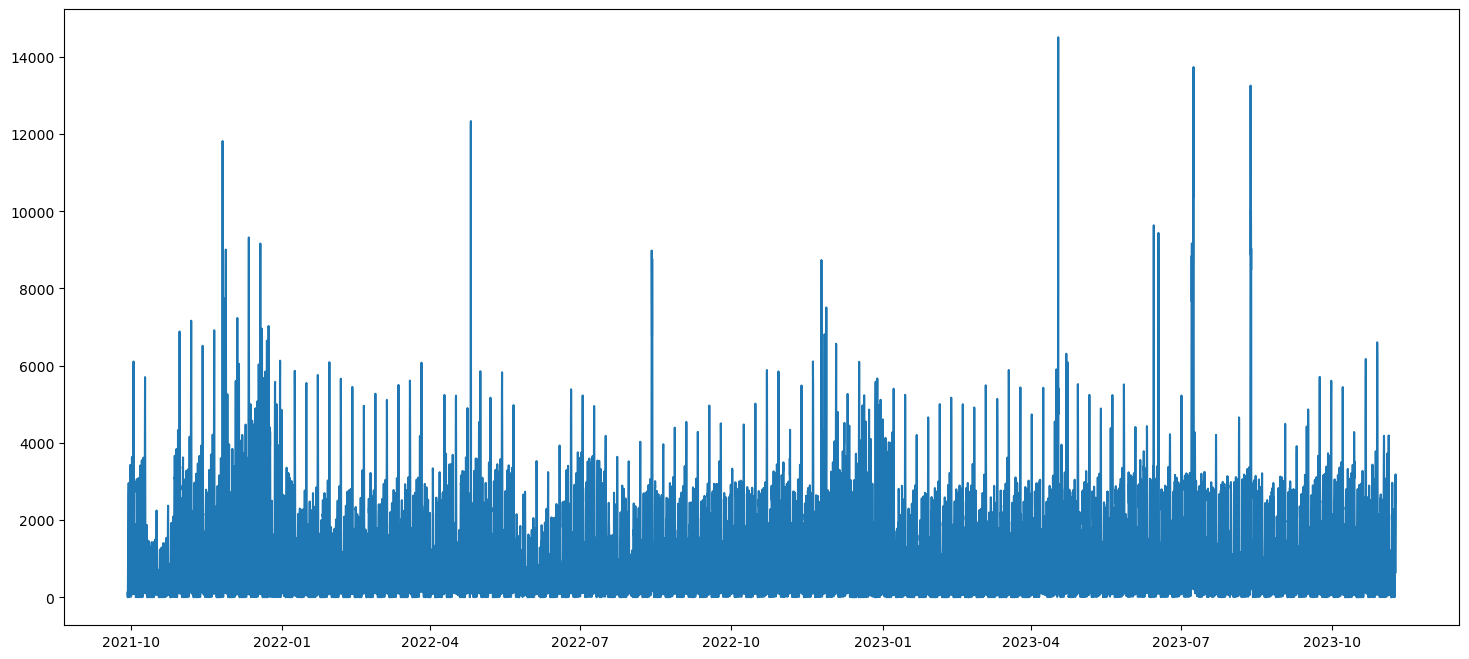

In [7]:
# Imputation with a factor

start_date1 = '2022-09-14 11:00:00'
end_date1 = '2022-12-22 23:00:00'
start_date2 = '2023-04-03 10:00:00'
end_date2 = '2023-09-22 07:00:00'

df_f = df_new[["datetime", "bhfs_south", "bhfs_middle", "bhfs_north"]].copy()
df_f.drop(df_f[(df_f['datetime'] >= start_date1) & (df_f['datetime'] <= end_date1)].index, inplace=True)
df_f.drop(df_f[(df_f['datetime'] >= start_date2) & (df_f['datetime'] <= end_date2)].index, inplace=True)

factor = (df_f.bhfs_north.mean())/(df_f.bhfs_middle.mean() + df_f.bhfs_south.mean())

df_factor = df_new[["datetime", "bhfs_south", "bhfs_middle", "bhfs_north"]].copy()

df_factor["bhfs_north"].fillna((df_factor["bhfs_middle"] + df_factor["bhfs_south"]) * factor, inplace=True)

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_factor.datetime, df_factor.bhfs_north);

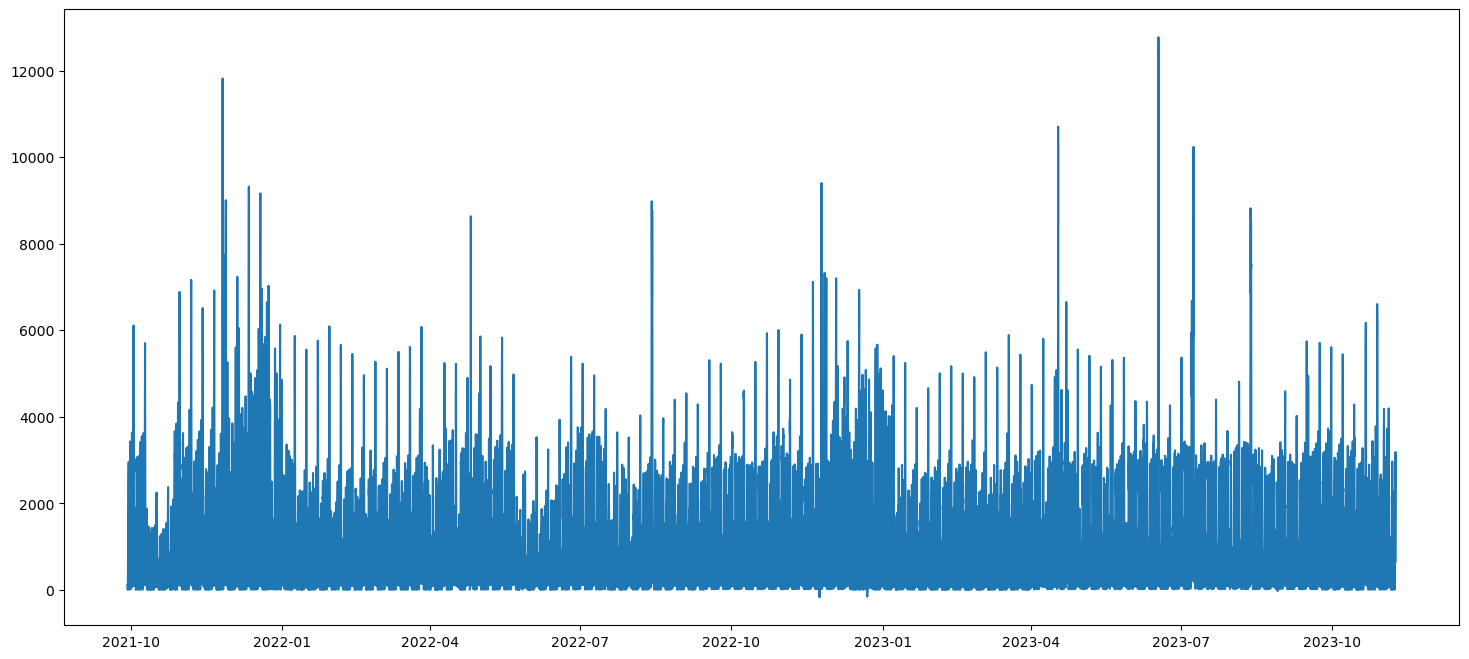

In [23]:
# Imputation with IterativeImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Assuming df_new is your DataFrame
df_ii = df_new[["datetime", "bhfs_south", "bhfs_middle", "bhfs_north"]].copy()

# Initialize IterativeImputer with custom imputation strategy
imputer = IterativeImputer(max_iter=10, random_state=0, imputation_order='ascending')

# Transform the data to fill missing values
df_imputed_values = imputer.fit_transform(df_ii[["bhfs_south", "bhfs_middle", "bhfs_north"]])

# Create a DataFrame with imputed values
df_imputed = pd.DataFrame(df_imputed_values, columns=["bhfs_south", "bhfs_middle", "bhfs_north"])

df_imputed["datetime"] = df_ii["datetime"]

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_imputed.datetime, df_imputed.bhfs_north);